# Autoencoders for Anomaly Detection

In this Assignment, you will again train an autoencoder to detect anomalies on the [ECG5000 dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000).

This time 10% of our training set is anomalies the labels are not available at training time. This is to reflect a truely unsupervised scenario where we may not have access to labeled data or a expert knowledge. Since the majority of our training data is still normal, we are still able to train a high performing model as long as we don't overfit to our training data.

In this assignment you will **first select the size of the encoding layer and try to maximize the AUC metric**. Be careful, if the model is too large it can learn to recreate the abnormal data as well as the normal data, and therefore do a worse job a distinguishing them.

Next, you will **pick a error threshold to maxmize accuracy, precision, and recall.** There is often a tradeoff between high precision and high recall, therefore it is up to you to decide what is important to our ECG classification application. Remember that our model predicts `1` when it predicts a normal rhythm.



### Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

### Load ECG data

Same as the previous colab

The dataset you will use is based on one from [timeseriesclassification.com](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000).


In [2]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [3]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

Normalize the data to `[0,1]` to improve training accuracy.


In [4]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

This time we are mixing in some of the anomaly data into the training set. 

10% of the training data will contain anomalies. Since the majority of the training data is still normal data, we can still train a high performing model as long as we don't overfit to the training data.

In [5]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

portion_of_anomaly_in_training = 0.1 #10% of training data will be anomalies
end_size = int(len(normal_train_data)/(10-portion_of_anomaly_in_training*10))
combined_train_data = np.append(normal_train_data, anomalous_test_data[:end_size], axis=0)
combined_train_data.shape

(2621, 140)

Plot a normal ECG. 

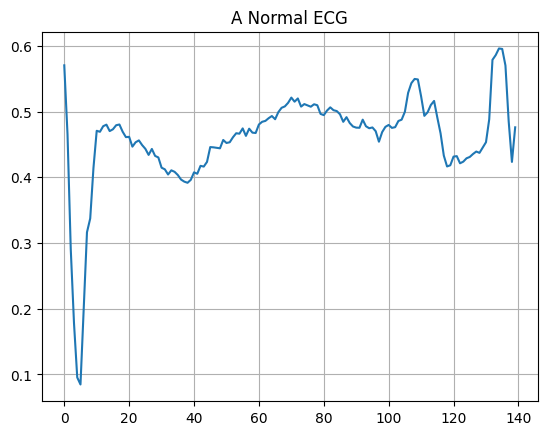

In [6]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

Plot an anomalous ECG.

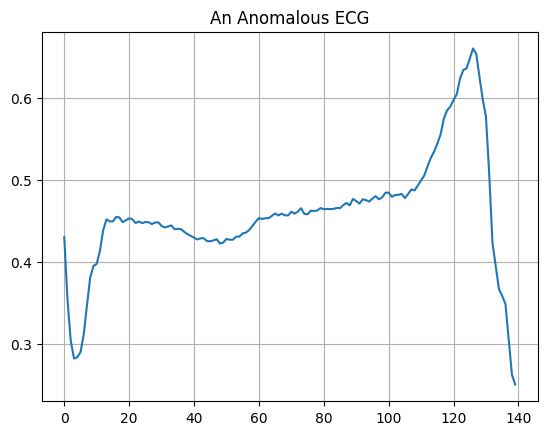

In [7]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### Picking an Embedding to Build the Model

After training and evaluating the example model, try modifying the size and number of layers to build an understanding for autoencoder architectures.

Note: Changing the size of the embedding (the smallest layer) can produce interesting results. Feel free to play around with that layer size.

In [32]:
EMBEDDING_SIZE = 2# YOUR CODE GOES HERE #

class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(8, activation="relu"),
      layers.Dense(EMBEDDING_SIZE, activation="relu")]) # Smallest Layer Defined Here
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(8, activation="relu"),
      layers.Dense(96, activation="relu"),
      layers.Dense(140, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()
print("Chosen Embedding Size: ", EMBEDDING_SIZE)

Chosen Embedding Size:  2


In [33]:
optimizer = tf.keras.optimizers.Adam(lr=0.01)
autoencoder.compile(optimizer=optimizer, loss='mae')

### Train the model

Notice that the autoencoder is now trained using the combined training data which is primarily normal ECGs with some anomalies mixed in. It is still evaluated using the full test set.

In [34]:
history = autoencoder.fit(combined_train_data, combined_train_data, epochs=50, 
                          batch_size=512, validation_data=(test_data, test_data), shuffle=True)

Epoch 1/50
6/6 [==============================] - 3s 35ms/step - loss: 0.0571 - val_loss: 0.0536
Epoch 2/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0560 - val_loss: 0.0526
Epoch 3/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0550 - val_loss: 0.0518
Epoch 4/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0540 - val_loss: 0.0509
Epoch 5/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0530 - val_loss: 0.0501
Epoch 6/50
6/6 [==============================] - 0s 12ms/step - loss: 0.0520 - val_loss: 0.0494
Epoch 7/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0511 - val_loss: 0.0486
Epoch 8/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0502 - val_loss: 0.0480
Epoch 9/50
6/6 [==============================] - 0s 10ms/step - loss: 0.0494 - val_loss: 0.0473
Epoch 10/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0485 - val_loss: 0.0467
Epoch 11/50
6/6 [==================

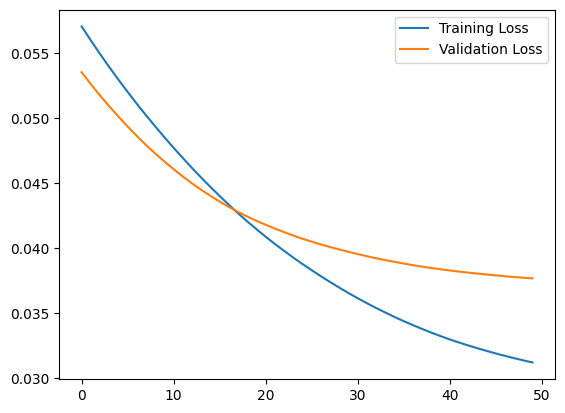

In [35]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

### Evaluate Training

You will soon classify an ECG as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

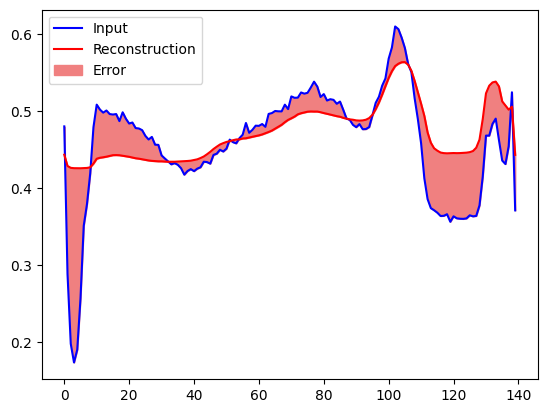

In [36]:
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(normal_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140), decoded_imgs[0], normal_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Create a similar plot, this time for an anomalous test example.

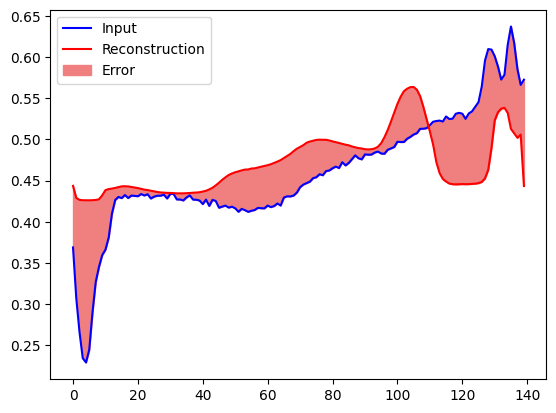

In [37]:
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(anomalous_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140), decoded_imgs[0], anomalous_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### ROC and AUC Metrics

The Receiver Operating Characteristic (ROC) plots allows us to visualize the tradeoff between predicting anomalies as normal (false positives) and predicting normal data as an anomaly (false negative). Normal rhythms are labeled as `1` in this dataset but we have to flip them here to match the ROC curves expectations.

The ROC plot now has threshold values plotted on their corrispoinding points on the curve to aid in selecting a theshold for the application.

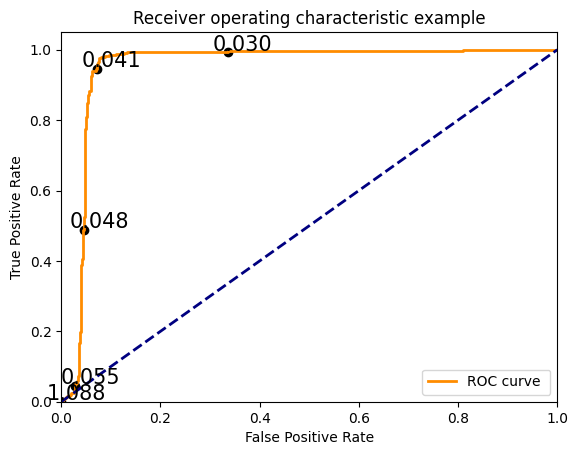

In [38]:
reconstructions = autoencoder(test_data)
loss = tf.keras.losses.mae(reconstructions, test_data)
fpr = []
tpr = []
#the test labels are flipped to match how the roc_curve function expects them.
flipped_labels = 1-test_labels 
fpr, tpr, thresholds = roc_curve(flipped_labels, loss)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

# plot some thresholds
thresholds_every=20
thresholdsLength = len(thresholds)
colorMap=plt.get_cmap('jet', thresholdsLength)
for i in range(0, thresholdsLength, thresholds_every):
  threshold_value_with_max_four_decimals = str(thresholds[i])[:5]
  plt.scatter(fpr[i], tpr[i], c='black')
  plt.text(fpr[i] - 0.03, tpr[i] + 0.005, threshold_value_with_max_four_decimals, fontdict={'size': 15});

plt.show()


Since our model does a great job in diferentiating normal rythms from abnormal ones it seems easy to pick the threshold that would give us the high true positive rate (TPR) and low false positive rate (FPR) that is at the 'knee' of the curve.

However, in some cases there may be an application constraint that requires a specific TPR or FPR, in which case we would have to move off of the 'knee' and sacrifice overall accuracy. In this case we might rather have false alarms than miss a potentially dangerous rythm.

Now that we understand how to visualize the impact of the selected threshold, we calculate the area under the ROC curve (AUC). 

This metric is very useful for evalutation of a specfic model design. Adjust the size of the encoding layer (smallest layer) in the autoencoder to maximize this metric.

In [39]:
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.9512987012987013


### Picking a Threshold to Detect Anomalies
Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold.

Try to maximize the accuracy, precision, and recall. Think about the application and the consequences of a false positive and a false negative. The course staff was able to acheive greater than 94% on all three at the same time!

[More details on precision and recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)

74/74 [==============================] - 0s 2ms/step


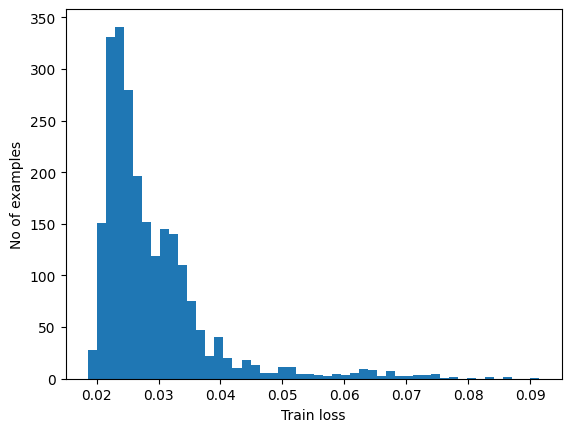

In [40]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [41]:
threshold = np.mean(train_loss) + np.std(train_loss) # YOUR CODE GOES HERE #
print("Chosen Threshold: ", threshold)

Chosen Threshold:  0.038591202


In [42]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold), loss

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))


In [43]:
preds, scores = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.94
Precision = 0.9844961240310077
Recall = 0.9071428571428571
